# About this notebook  

TBD...

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True

# Data Loading

In [2]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
os.listdir("../input/cassava-leaf-disease-classification")

['train_tfrecords',
 'train_images',
 'test_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_tfrecords']

In [4]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

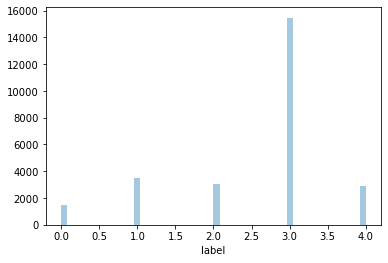

In [5]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = (
        "vit_base_patch16_384"  # resnext50_32x4d, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns, vit_base_patch16_384
    )
    batch_size = 16  # resnext50_32x4d: 14-30, tf_efficientnet_b3_ns:10-22, tf_efficientnet_b4_ns: 8-16
    gradient_accumulation_steps = 2
    size = 384 if model_name.startswith("vit_base_") else 512  # 512 if ON_KAGGLE else 384
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = "CosineAnnealingWarmupRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs
    )  # CosineAnnealingWarmRestarts
    first_cycle_steps = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs
    )  # CosineAnnealingWarmupRestarts for batch update
    warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 2e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 1012
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [10]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

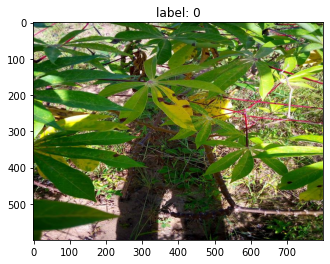

In [12]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

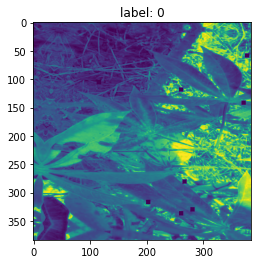

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [15]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [16]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [17]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if model_name == "resnext50_32x4d":
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG.target_size)

        elif model_name.startswith("tf_efficientnet"):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.target_size)

        elif model_name.startswith("vit_base_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    elif CFG.model_name.startswith("resnext50_32x4d") and False:
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2}: {type(child2)} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                if isinstance(child2, nn.modules.container.Sequential):
                    for child3 in child2.children():
                        for child4 in child3.children():
                            if isinstance(child4, nn.BatchNorm2d):
                                # print(child4)
                                for param in child4.parameters():
                                    param.requires_grad = False
                                    # print(param.requires_grad)

In [19]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.7146, -0.7067,  0.6645, -0.1729, -1.1041],
        [-0.2281,  0.2803,  0.7576,  0.3792, -0.3958],
        [-0.7118,  0.4203,  1.6510,  0.9902,  0.3857],
        [ 0.3163, -0.5549,  0.4828, -0.1016, -0.5321]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [20]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [22]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [23]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [24]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_384-83fb41ba.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_384-83fb41ba.pth


Epoch: [1][0/1316] Elapsed 0m 2s (remain 46m 46s) Loss: 0.5428(0.5428) Grad: 1.7861 LR: 0.000002  
Epoch: [1][100/1316] Elapsed 0m 31s (remain 6m 24s) Loss: 0.2663(0.3915) Grad: 0.6413 LR: 0.000017  
Epoch: [1][200/1316] Elapsed 1m 1s (remain 5m 43s) Loss: 0.2352(0.3476) Grad: 0.8961 LR: 0.000032  
Epoch: [1][300/1316] Elapsed 1m 31s (remain 5m 9s) Loss: 0.2396(0.3171) Grad: 0.6620 LR: 0.000047  
Epoch: [1][400/1316] Elapsed 2m 1s (remain 4m 37s) Loss: 0.1692(0.3002) Grad: 0.8140 LR: 0.000062  
Epoch: [1][500/1316] Elapsed 2m 31s (remain 4m 6s) Loss: 0.2114(0.2890) Grad: 1.5047 LR: 0.000077  
Epoch: [1][600/1316] Elapsed 3m 0s (remain 3m 35s) Loss: 0.3789(0.2807) Grad: 1.1844 LR: 0.000092  
Epoch: [1][700/1316] Elapsed 3m 30s (remain 3m 4s) Loss: 0.1590(0.2754) Grad: 0.4637 LR: 0.000107  
Epoch: [1][800/1316] Elapsed 4m 0s (remain 2m 34s) Loss: 0.0602(0.2701) Grad: 0.4934 LR: 0.000122  
Epoch: [1][900/1316] Elapsed 4m 29s (remain 2m 4s) Loss: 0.1963(0.2658) Grad: 1.0775 LR: 0.000137  


Epoch 1 - avg_train_loss: 0.2533  avg_val_loss: 0.1349  time: 431s
Epoch 1 - Accuracy: 0.8509870918754746
Epoch 1 - Save Best Score: 0.8510 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1420(0.1349) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 28m 51s) Loss: 0.0752(0.0752) Grad: 0.5536 LR: 0.000200  
Epoch: [2][100/1316] Elapsed 0m 31s (remain 6m 15s) Loss: 0.2674(0.2133) Grad: 0.4518 LR: 0.000200  
Epoch: [2][200/1316] Elapsed 1m 1s (remain 5m 38s) Loss: 0.0811(0.2151) Grad: 0.3119 LR: 0.000200  
Epoch: [2][300/1316] Elapsed 1m 30s (remain 5m 6s) Loss: 0.3596(0.2130) Grad: 0.4387 LR: 0.000200  
Epoch: [2][400/1316] Elapsed 2m 0s (remain 4m 35s) Loss: 0.1509(0.2168) Grad: 0.5531 LR: 0.000199  
Epoch: [2][500/1316] Elapsed 2m 30s (remain 4m 5s) Loss: 0.2298(0.2188) Grad: 0.5543 LR: 0.000199  
Epoch: [2][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.3840(0.2217) Grad: 0.8272 LR: 0.000199  
Epoch: [2][700/1316] Elapsed 3m 30s (remain 3m 4s) Loss: 0.2982(0.2207) Grad: 0.4075 LR: 0.000198  
Epoch: [2][800/1316] Elapsed 3m 59s (remain 2m 34s) Loss: 0.1958(0.2184) Grad: 0.3640 LR: 0.000198  
Epoch: [2][900/1316] Elapsed 4m

Epoch 2 - avg_train_loss: 0.2173  avg_val_loss: 0.1387  time: 427s
Epoch 2 - Accuracy: 0.8507972665148064


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0367(0.1387) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 29m 19s) Loss: 0.0840(0.0840) Grad: 0.4959 LR: 0.000194  
Epoch: [3][100/1316] Elapsed 0m 31s (remain 6m 13s) Loss: 0.3093(0.2091) Grad: 0.5326 LR: 0.000193  
Epoch: [3][200/1316] Elapsed 1m 0s (remain 5m 36s) Loss: 0.3932(0.1989) Grad: 0.3147 LR: 0.000192  
Epoch: [3][300/1316] Elapsed 1m 30s (remain 5m 5s) Loss: 0.1484(0.2050) Grad: 0.3270 LR: 0.000191  
Epoch: [3][400/1316] Elapsed 2m 0s (remain 4m 34s) Loss: 0.1302(0.2064) Grad: 0.4930 LR: 0.000190  
Epoch: [3][500/1316] Elapsed 2m 30s (remain 4m 4s) Loss: 0.2671(0.2106) Grad: 0.3830 LR: 0.000189  
Epoch: [3][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.2045(0.2111) Grad: 0.3691 LR: 0.000187  
Epoch: [3][700/1316] Elapsed 3m 29s (remain 3m 4s) Loss: 0.2846(0.2126) Grad: 0.1905 LR: 0.000186  
Epoch: [3][800/1316] Elapsed 3m 59s (remain 2m 34s) Loss: 0.2731(0.2116) Grad: 0.1987 LR: 0.000185  
Epoch: [3][900/1316] Elapsed 4m

Epoch 3 - avg_train_loss: 0.2131  avg_val_loss: 0.1363  time: 427s
Epoch 3 - Accuracy: 0.8470007593014427


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0817(0.1363) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 27m 7s) Loss: 0.3022(0.3022) Grad: 0.6510 LR: 0.000177  
Epoch: [4][100/1316] Elapsed 0m 31s (remain 6m 13s) Loss: 0.3088(0.2086) Grad: 0.5238 LR: 0.000175  
Epoch: [4][200/1316] Elapsed 1m 0s (remain 5m 36s) Loss: 0.1377(0.2042) Grad: 0.3237 LR: 0.000173  
Epoch: [4][300/1316] Elapsed 1m 30s (remain 5m 5s) Loss: 0.2154(0.2020) Grad: 0.3306 LR: 0.000172  
Epoch: [4][400/1316] Elapsed 2m 0s (remain 4m 34s) Loss: 0.2371(0.2038) Grad: 0.5485 LR: 0.000170  
Epoch: [4][500/1316] Elapsed 2m 30s (remain 4m 4s) Loss: 0.2832(0.2057) Grad: 0.4172 LR: 0.000168  
Epoch: [4][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.2432(0.2054) Grad: 0.4362 LR: 0.000166  
Epoch: [4][700/1316] Elapsed 3m 29s (remain 3m 4s) Loss: 0.1690(0.2055) Grad: 0.3806 LR: 0.000164  
Epoch: [4][800/1316] Elapsed 3m 59s (remain 2m 34s) Loss: 0.1405(0.2055) Grad: 0.3316 LR: 0.000162  
Epoch: [4][900/1316] Elapsed 4m 

Epoch 4 - avg_train_loss: 0.2048  avg_val_loss: 0.1381  time: 427s
Epoch 4 - Accuracy: 0.8519362186788155
Epoch 4 - Save Best Score: 0.8519 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.1313(0.1381) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 29m 12s) Loss: 0.0941(0.0941) Grad: 0.4241 LR: 0.000150  
Epoch: [5][100/1316] Elapsed 0m 31s (remain 6m 15s) Loss: 0.2624(0.2034) Grad: 0.3680 LR: 0.000148  
Epoch: [5][200/1316] Elapsed 1m 1s (remain 5m 38s) Loss: 0.2867(0.2147) Grad: 0.2114 LR: 0.000146  
Epoch: [5][300/1316] Elapsed 1m 30s (remain 5m 6s) Loss: 0.0106(0.2100) Grad: 0.0600 LR: 0.000144  
Epoch: [5][400/1316] Elapsed 2m 0s (remain 4m 35s) Loss: 0.2188(0.2071) Grad: 0.2371 LR: 0.000141  
Epoch: [5][500/1316] Elapsed 2m 30s (remain 4m 4s) Loss: 0.0402(0.2051) Grad: 0.2399 LR: 0.000139  
Epoch: [5][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.3695(0.2026) Grad: 0.4628 LR: 0.000136  
Epoch: [5][700/1316] Elapsed 3m 29s (remain 3m 4s) Loss: 0.1502(0.2026) Grad: inf LR: 0.000134  
Epoch: [5][800/1316] Elapsed 3m 59s (remain 2m 33s) Loss: 0.2797(0.2034) Grad: 0.1858 LR: 0.000131  
Epoch: [5][900/1316] Elapsed 4m 29

Epoch 5 - avg_train_loss: 0.1998  avg_val_loss: 0.1271  time: 426s
Epoch 5 - Accuracy: 0.860668185269552
Epoch 5 - Save Best Score: 0.8607 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.1159(0.1271) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 27m 21s) Loss: 0.1860(0.1860) Grad: 0.4284 LR: 0.000118  
Epoch: [6][100/1316] Elapsed 0m 31s (remain 6m 14s) Loss: 0.2929(0.1821) Grad: 0.4713 LR: 0.000116  
Epoch: [6][200/1316] Elapsed 1m 0s (remain 5m 36s) Loss: 0.1166(0.1925) Grad: 0.5211 LR: 0.000113  
Epoch: [6][300/1316] Elapsed 1m 30s (remain 5m 5s) Loss: 0.3352(0.1927) Grad: 0.3987 LR: 0.000110  
Epoch: [6][400/1316] Elapsed 2m 0s (remain 4m 35s) Loss: 0.3278(0.1929) Grad: 0.2388 LR: 0.000108  
Epoch: [6][500/1316] Elapsed 2m 30s (remain 4m 4s) Loss: 0.1507(0.1907) Grad: 0.4054 LR: 0.000105  
Epoch: [6][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.2006(0.1901) Grad: 0.3395 LR: 0.000103  
Epoch: [6][700/1316] Elapsed 3m 30s (remain 3m 4s) Loss: 0.2003(0.1882) Grad: 0.5281 LR: 0.000100  
Epoch: [6][800/1316] Elapsed 4m 0s (remain 2m 34s) Loss: 0.2376(0.1900) Grad: 0.2446 LR: 0.000097  
Epoch: [6][900/1316] Elapsed 4m 

Epoch 6 - avg_train_loss: 0.1874  avg_val_loss: 0.1137  time: 427s
Epoch 6 - Accuracy: 0.8686408504176157
Epoch 6 - Save Best Score: 0.8686 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0366(0.1137) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 28m 25s) Loss: 0.0707(0.0707) Grad: 0.3934 LR: 0.000084  
Epoch: [7][100/1316] Elapsed 0m 30s (remain 6m 9s) Loss: 0.1169(0.1292) Grad: 0.4464 LR: 0.000081  
Epoch: [7][200/1316] Elapsed 1m 0s (remain 5m 34s) Loss: 0.3442(0.1340) Grad: 0.4801 LR: 0.000079  
Epoch: [7][300/1316] Elapsed 1m 29s (remain 5m 3s) Loss: 0.2172(0.1387) Grad: 0.2383 LR: 0.000076  
Epoch: [7][400/1316] Elapsed 1m 59s (remain 4m 32s) Loss: 0.1855(0.1388) Grad: 0.4757 LR: 0.000074  
Epoch: [7][500/1316] Elapsed 2m 29s (remain 4m 2s) Loss: 0.1821(0.1433) Grad: 0.6444 LR: 0.000071  
Epoch: [7][600/1316] Elapsed 2m 58s (remain 3m 32s) Loss: 0.1859(0.1433) Grad: 0.3800 LR: 0.000069  
Epoch: [7][700/1316] Elapsed 3m 28s (remain 3m 2s) Loss: 0.0282(0.1443) Grad: 0.3050 LR: 0.000066  
Epoch: [7][800/1316] Elapsed 3m 57s (remain 2m 32s) Loss: 0.2949(0.1447) Grad: 0.5525 LR: 0.000064  
Epoch: [7][900/1316] Elapsed 4

Epoch 7 - avg_train_loss: 0.1432  avg_val_loss: 0.1093  time: 423s
Epoch 7 - Accuracy: 0.8798405466970387
Epoch 7 - Save Best Score: 0.8798 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0233(0.1093) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 30m 8s) Loss: 0.1981(0.1981) Grad: 0.1732 LR: 0.000052  
Epoch: [8][100/1316] Elapsed 0m 30s (remain 6m 12s) Loss: 0.2908(0.1559) Grad: 0.2465 LR: 0.000049  
Epoch: [8][200/1316] Elapsed 1m 0s (remain 5m 35s) Loss: 0.1918(0.1495) Grad: 0.6705 LR: 0.000047  
Epoch: [8][300/1316] Elapsed 1m 30s (remain 5m 3s) Loss: 0.1947(0.1490) Grad: 0.2781 LR: 0.000045  
Epoch: [8][400/1316] Elapsed 1m 59s (remain 4m 33s) Loss: 0.1616(0.1491) Grad: 0.2178 LR: 0.000043  
Epoch: [8][500/1316] Elapsed 2m 29s (remain 4m 2s) Loss: 0.1302(0.1481) Grad: 0.5502 LR: 0.000041  
Epoch: [8][600/1316] Elapsed 2m 58s (remain 3m 32s) Loss: 0.1074(0.1457) Grad: 0.4345 LR: 0.000039  
Epoch: [8][700/1316] Elapsed 3m 28s (remain 3m 2s) Loss: 0.1208(0.1425) Grad: 0.6365 LR: 0.000037  
Epoch: [8][800/1316] Elapsed 3m 57s (remain 2m 32s) Loss: 0.3102(0.1389) Grad: 0.3305 LR: 0.000035  
Epoch: [8][900/1316] Elapsed 4

Epoch 8 - avg_train_loss: 0.1354  avg_val_loss: 0.1062  time: 423s
Epoch 8 - Accuracy: 0.886294608959757
Epoch 8 - Save Best Score: 0.8863 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0464(0.1062) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 28m 43s) Loss: 0.1892(0.1892) Grad: 0.2750 LR: 0.000025  
Epoch: [9][100/1316] Elapsed 0m 30s (remain 6m 9s) Loss: 0.1217(0.1308) Grad: 0.1885 LR: 0.000024  
Epoch: [9][200/1316] Elapsed 1m 0s (remain 5m 33s) Loss: 0.1098(0.1281) Grad: 0.3645 LR: 0.000022  
Epoch: [9][300/1316] Elapsed 1m 29s (remain 5m 2s) Loss: 0.1205(0.1330) Grad: 0.5176 LR: 0.000020  
Epoch: [9][400/1316] Elapsed 1m 59s (remain 4m 31s) Loss: 0.1117(0.1325) Grad: 0.2396 LR: 0.000019  
Epoch: [9][500/1316] Elapsed 2m 28s (remain 4m 1s) Loss: 0.3395(0.1284) Grad: 0.3650 LR: 0.000017  
Epoch: [9][600/1316] Elapsed 2m 57s (remain 3m 31s) Loss: 0.0157(0.1289) Grad: 0.1640 LR: 0.000016  
Epoch: [9][700/1316] Elapsed 3m 27s (remain 3m 1s) Loss: 0.1465(0.1308) Grad: 0.2817 LR: 0.000015  
Epoch: [9][800/1316] Elapsed 3m 56s (remain 2m 32s) Loss: 0.0891(0.1293) Grad: 0.6413 LR: 0.000013  
Epoch: [9][900/1316] Elapsed 4

Epoch 9 - avg_train_loss: 0.1270  avg_val_loss: 0.1054  time: 421s
Epoch 9 - Accuracy: 0.8851556567957479


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0668(0.1054) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 26m 2s) Loss: 0.0363(0.0363) Grad: 0.3048 LR: 0.000008  
Epoch: [10][100/1316] Elapsed 0m 29s (remain 5m 55s) Loss: 0.0864(0.0807) Grad: 0.5307 LR: 0.000007  
Epoch: [10][200/1316] Elapsed 0m 57s (remain 5m 21s) Loss: 0.0234(0.0777) Grad: 0.2803 LR: 0.000006  
Epoch: [10][300/1316] Elapsed 1m 26s (remain 4m 50s) Loss: 0.0982(0.0785) Grad: 0.2528 LR: 0.000006  
Epoch: [10][400/1316] Elapsed 1m 54s (remain 4m 21s) Loss: 0.0251(0.0785) Grad: 0.3154 LR: 0.000005  
Epoch: [10][500/1316] Elapsed 2m 22s (remain 3m 52s) Loss: 0.0598(0.0769) Grad: 0.3809 LR: 0.000004  
Epoch: [10][600/1316] Elapsed 2m 51s (remain 3m 23s) Loss: 0.1112(0.0755) Grad: 0.3940 LR: 0.000004  
Epoch: [10][700/1316] Elapsed 3m 19s (remain 2m 55s) Loss: 0.0138(0.0746) Grad: 0.2351 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 3m 48s (remain 2m 26s) Loss: 0.0604(0.0738) Grad: 0.4372 LR: 0.000003  
Epoch: [10][900/1

Epoch 10 - avg_train_loss: 0.0731  avg_val_loss: 0.1024  time: 407s
Epoch 10 - Accuracy: 0.8880030372057707
Epoch 10 - Save Best Score: 0.8880 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0487(0.1024) 


Epoch 10 - Save final model
========== fold: 0 result ==========
Score: 0.88800
========== fold: 1 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 28m 21s) Loss: 0.6651(0.6651) Grad: 1.5658 LR: 0.000002  
Epoch: [1][100/1316] Elapsed 0m 32s (remain 6m 27s) Loss: 0.4098(0.4163) Grad: 0.7301 LR: 0.000017  
Epoch: [1][200/1316] Elapsed 1m 3s (remain 5m 49s) Loss: 0.1597(0.3636) Grad: 0.9033 LR: 0.000032  
Epoch: [1][300/1316] Elapsed 1m 33s (remain 5m 15s) Loss: 0.2924(0.3298) Grad: 0.6229 LR: 0.000047  
Epoch: [1][400/1316] Elapsed 2m 4s (remain 4m 43s) Loss: 0.0165(0.3080) Grad: 0.4946 LR: 0.000062  
Epoch: [1][500/1316] Elapsed 2m 35s (remain 4m 12s) Loss: 0.2106(0.2983) Grad: 0.5625 LR: 0.000077  
Epoch: [1][600/1316] Elapsed 3m 5s (remain 3m 40s) Loss: 0.0706(0.2880) Grad: 0.3906 LR: 0.000092  
Epoch: [1][700/1316] Elapsed 3m 36s (remain 3m 10s) Loss: 0.2002(0.2810) Grad: 0.5361 LR: 0.000107  
Epoch: [1][800/1316] Elapsed 4m 7s (remain 2m 39s) Loss: 0.2839(0.2757) Grad: 0.9306 LR: 0.000122  
Epoch: [1][900/1316] Elapsed 4m 38s (remain 2m 8s) Loss: 0.1379(0.2717) Grad: 0.6357 LR: 0.000137

Epoch 1 - avg_train_loss: 0.2567  avg_val_loss: 0.1401  time: 439s
Epoch 1 - Accuracy: 0.8426347760060744
Epoch 1 - Save Best Score: 0.8426 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0024(0.1401) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 29m 43s) Loss: 0.1765(0.1765) Grad: 0.6724 LR: 0.000200  
Epoch: [2][100/1316] Elapsed 0m 32s (remain 6m 25s) Loss: 0.3043(0.2195) Grad: 0.5133 LR: 0.000200  
Epoch: [2][200/1316] Elapsed 1m 2s (remain 5m 47s) Loss: 0.2707(0.2281) Grad: 0.8410 LR: 0.000200  
Epoch: [2][300/1316] Elapsed 1m 33s (remain 5m 14s) Loss: 0.2788(0.2249) Grad: 0.8428 LR: 0.000200  
Epoch: [2][400/1316] Elapsed 2m 3s (remain 4m 42s) Loss: 0.1955(0.2225) Grad: 0.3634 LR: 0.000199  
Epoch: [2][500/1316] Elapsed 2m 34s (remain 4m 11s) Loss: 0.2893(0.2237) Grad: 0.7654 LR: 0.000199  
Epoch: [2][600/1316] Elapsed 3m 5s (remain 3m 40s) Loss: 0.2033(0.2210) Grad: 0.6421 LR: 0.000199  
Epoch: [2][700/1316] Elapsed 3m 36s (remain 3m 9s) Loss: 0.3519(0.2222) Grad: 0.6000 LR: 0.000198  
Epoch: [2][800/1316] Elapsed 4m 7s (remain 2m 38s) Loss: 0.1678(0.2235) Grad: 0.2727 LR: 0.000198  
Epoch: [2][900/1316] Elapsed 4

Epoch 2 - avg_train_loss: 0.2202  avg_val_loss: 0.1264  time: 438s
Epoch 2 - Accuracy: 0.856492027334852
Epoch 2 - Save Best Score: 0.8565 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0011(0.1264) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 31m 6s) Loss: 0.1394(0.1394) Grad: 0.4788 LR: 0.000194  
Epoch: [3][100/1316] Elapsed 0m 32s (remain 6m 25s) Loss: 0.2103(0.2091) Grad: 0.3113 LR: 0.000193  
Epoch: [3][200/1316] Elapsed 1m 2s (remain 5m 47s) Loss: 0.1680(0.2092) Grad: 0.5630 LR: 0.000192  
Epoch: [3][300/1316] Elapsed 1m 33s (remain 5m 13s) Loss: 0.1174(0.2117) Grad: 0.5146 LR: 0.000191  
Epoch: [3][400/1316] Elapsed 2m 3s (remain 4m 42s) Loss: 0.3118(0.2147) Grad: 0.7183 LR: 0.000190  
Epoch: [3][500/1316] Elapsed 2m 34s (remain 4m 11s) Loss: 0.2931(0.2138) Grad: 0.2397 LR: 0.000189  
Epoch: [3][600/1316] Elapsed 3m 5s (remain 3m 40s) Loss: 0.3250(0.2128) Grad: 0.3994 LR: 0.000187  
Epoch: [3][700/1316] Elapsed 3m 35s (remain 3m 9s) Loss: 0.3230(0.2125) Grad: 0.8142 LR: 0.000186  
Epoch: [3][800/1316] Elapsed 4m 6s (remain 2m 38s) Loss: 0.2769(0.2132) Grad: 0.5563 LR: 0.000185  
Epoch: [3][900/1316] Elapsed 4m

Epoch 3 - avg_train_loss: 0.2125  avg_val_loss: 0.1486  time: 438s
Epoch 3 - Accuracy: 0.8276385725132878


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0066(0.1486) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 28m 40s) Loss: 0.2419(0.2419) Grad: 0.2998 LR: 0.000177  
Epoch: [4][100/1316] Elapsed 0m 31s (remain 6m 24s) Loss: 0.0826(0.2065) Grad: 0.3201 LR: 0.000175  
Epoch: [4][200/1316] Elapsed 1m 3s (remain 5m 49s) Loss: 0.1713(0.2092) Grad: 0.2808 LR: 0.000173  
Epoch: [4][300/1316] Elapsed 1m 33s (remain 5m 16s) Loss: 0.3468(0.2056) Grad: 0.4202 LR: 0.000172  
Epoch: [4][400/1316] Elapsed 2m 4s (remain 4m 44s) Loss: 0.2046(0.2073) Grad: 0.2299 LR: 0.000170  
Epoch: [4][500/1316] Elapsed 2m 35s (remain 4m 12s) Loss: 0.2670(0.2059) Grad: 0.4355 LR: 0.000168  
Epoch: [4][600/1316] Elapsed 3m 6s (remain 3m 41s) Loss: 0.0638(0.2029) Grad: 0.3719 LR: 0.000166  
Epoch: [4][700/1316] Elapsed 3m 36s (remain 3m 10s) Loss: 0.1766(0.2049) Grad: 0.2379 LR: 0.000164  
Epoch: [4][800/1316] Elapsed 4m 7s (remain 2m 39s) Loss: 0.3012(0.2056) Grad: 0.5415 LR: 0.000162  
Epoch: [4][900/1316] Elapsed 

Epoch 4 - avg_train_loss: 0.2063  avg_val_loss: 0.1190  time: 438s
Epoch 4 - Accuracy: 0.8665527714502658
Epoch 4 - Save Best Score: 0.8666 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0065(0.1190) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 30m 9s) Loss: 0.3862(0.3862) Grad: 0.5055 LR: 0.000150  
Epoch: [5][100/1316] Elapsed 0m 32s (remain 6m 26s) Loss: 0.1110(0.1997) Grad: 0.0828 LR: 0.000148  
Epoch: [5][200/1316] Elapsed 1m 2s (remain 5m 47s) Loss: 0.2710(0.1995) Grad: 0.3695 LR: 0.000146  
Epoch: [5][300/1316] Elapsed 1m 33s (remain 5m 15s) Loss: 0.1949(0.2034) Grad: 0.3509 LR: 0.000144  
Epoch: [5][400/1316] Elapsed 2m 4s (remain 4m 43s) Loss: 0.1837(0.2024) Grad: 0.2143 LR: 0.000141  
Epoch: [5][500/1316] Elapsed 2m 35s (remain 4m 12s) Loss: 0.1304(0.2025) Grad: 0.6065 LR: 0.000139  
Epoch: [5][600/1316] Elapsed 3m 5s (remain 3m 41s) Loss: 0.0871(0.2016) Grad: 0.4026 LR: 0.000136  
Epoch: [5][700/1316] Elapsed 3m 36s (remain 3m 10s) Loss: 0.1169(0.2007) Grad: 0.3648 LR: 0.000134  
Epoch: [5][800/1316] Elapsed 4m 7s (remain 2m 39s) Loss: 0.0741(0.2001) Grad: 0.2959 LR: 0.000131  
Epoch: [5][900/1316] Elapsed 4

Epoch 5 - avg_train_loss: 0.2033  avg_val_loss: 0.1146  time: 440s
Epoch 5 - Accuracy: 0.8741457858769932
Epoch 5 - Save Best Score: 0.8741 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0038(0.1146) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 28m 30s) Loss: 0.2329(0.2329) Grad: 0.4537 LR: 0.000118  
Epoch: [6][100/1316] Elapsed 0m 32s (remain 6m 26s) Loss: 0.3650(0.2064) Grad: 0.3732 LR: 0.000116  
Epoch: [6][200/1316] Elapsed 1m 3s (remain 5m 50s) Loss: 0.0975(0.2044) Grad: 0.5348 LR: 0.000113  
Epoch: [6][300/1316] Elapsed 1m 33s (remain 5m 16s) Loss: 0.3668(0.2033) Grad: 0.3872 LR: 0.000110  
Epoch: [6][400/1316] Elapsed 2m 4s (remain 4m 43s) Loss: 0.3038(0.1963) Grad: 0.3718 LR: 0.000108  
Epoch: [6][500/1316] Elapsed 2m 35s (remain 4m 12s) Loss: 0.1879(0.1968) Grad: 0.2453 LR: 0.000105  
Epoch: [6][600/1316] Elapsed 3m 6s (remain 3m 41s) Loss: 0.1893(0.1938) Grad: 0.7076 LR: 0.000103  
Epoch: [6][700/1316] Elapsed 3m 36s (remain 3m 10s) Loss: 0.1055(0.1928) Grad: 0.4166 LR: 0.000100  
Epoch: [6][800/1316] Elapsed 4m 7s (remain 2m 39s) Loss: 0.2203(0.1913) Grad: 0.3235 LR: 0.000097  
Epoch: [6][900/1316] Elapsed 

Epoch 6 - avg_train_loss: 0.1950  avg_val_loss: 0.1102  time: 438s
Epoch 6 - Accuracy: 0.8790812452543659
Epoch 6 - Save Best Score: 0.8791 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0038(0.1102) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 29m 42s) Loss: 0.1257(0.1257) Grad: 0.2770 LR: 0.000084  
Epoch: [7][100/1316] Elapsed 0m 31s (remain 6m 23s) Loss: 0.1062(0.1496) Grad: 0.3257 LR: 0.000081  
Epoch: [7][200/1316] Elapsed 1m 2s (remain 5m 44s) Loss: 0.2638(0.1481) Grad: 0.3703 LR: 0.000079  
Epoch: [7][300/1316] Elapsed 1m 32s (remain 5m 11s) Loss: 0.1860(0.1495) Grad: 0.3591 LR: 0.000076  
Epoch: [7][400/1316] Elapsed 2m 2s (remain 4m 40s) Loss: 0.0019(0.1510) Grad: 0.0318 LR: 0.000074  
Epoch: [7][500/1316] Elapsed 2m 33s (remain 4m 9s) Loss: 0.0847(0.1493) Grad: 0.4457 LR: 0.000071  
Epoch: [7][600/1316] Elapsed 3m 3s (remain 3m 38s) Loss: 0.0364(0.1469) Grad: 0.3208 LR: 0.000069  
Epoch: [7][700/1316] Elapsed 3m 34s (remain 3m 7s) Loss: 0.0088(0.1463) Grad: 0.1183 LR: 0.000066  
Epoch: [7][800/1316] Elapsed 4m 4s (remain 2m 37s) Loss: 0.2835(0.1467) Grad: 0.4810 LR: 0.000064  
Epoch: [7][900/1316] Elapsed 4m

Epoch 7 - avg_train_loss: 0.1457  avg_val_loss: 0.1124  time: 434s
Epoch 7 - Accuracy: 0.873006833712984


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0020(0.1124) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 30m 4s) Loss: 0.0633(0.0633) Grad: 0.1796 LR: 0.000052  
Epoch: [8][100/1316] Elapsed 0m 32s (remain 6m 26s) Loss: 0.0987(0.1353) Grad: 0.4605 LR: 0.000049  
Epoch: [8][200/1316] Elapsed 1m 2s (remain 5m 45s) Loss: 0.0712(0.1316) Grad: 0.4894 LR: 0.000047  
Epoch: [8][300/1316] Elapsed 1m 32s (remain 5m 12s) Loss: 0.0465(0.1330) Grad: 0.3166 LR: 0.000045  
Epoch: [8][400/1316] Elapsed 2m 2s (remain 4m 40s) Loss: 0.0270(0.1337) Grad: 0.3919 LR: 0.000043  
Epoch: [8][500/1316] Elapsed 2m 32s (remain 4m 8s) Loss: 0.0740(0.1329) Grad: 0.4595 LR: 0.000041  
Epoch: [8][600/1316] Elapsed 3m 3s (remain 3m 37s) Loss: 0.2554(0.1329) Grad: 0.3496 LR: 0.000039  
Epoch: [8][700/1316] Elapsed 3m 33s (remain 3m 7s) Loss: 0.1734(0.1330) Grad: 0.4016 LR: 0.000037  
Epoch: [8][800/1316] Elapsed 4m 3s (remain 2m 36s) Loss: 0.0779(0.1333) Grad: 0.3360 LR: 0.000035  
Epoch: [8][900/1316] Elapsed 4m 

Epoch 8 - avg_train_loss: 0.1352  avg_val_loss: 0.1022  time: 433s
Epoch 8 - Accuracy: 0.8870539104024298
Epoch 8 - Save Best Score: 0.8871 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0025(0.1022) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 29m 30s) Loss: 0.1103(0.1103) Grad: 0.4273 LR: 0.000025  
Epoch: [9][100/1316] Elapsed 0m 31s (remain 6m 20s) Loss: 0.0134(0.1301) Grad: 0.1332 LR: 0.000024  
Epoch: [9][200/1316] Elapsed 1m 1s (remain 5m 43s) Loss: 0.0404(0.1236) Grad: 0.3269 LR: 0.000022  
Epoch: [9][300/1316] Elapsed 1m 32s (remain 5m 10s) Loss: 0.1275(0.1302) Grad: 0.3726 LR: 0.000020  
Epoch: [9][400/1316] Elapsed 2m 2s (remain 4m 39s) Loss: 0.0849(0.1305) Grad: 0.3023 LR: 0.000019  
Epoch: [9][500/1316] Elapsed 2m 32s (remain 4m 8s) Loss: 0.0338(0.1309) Grad: 0.4397 LR: 0.000017  
Epoch: [9][600/1316] Elapsed 3m 2s (remain 3m 37s) Loss: 0.1784(0.1312) Grad: 0.5933 LR: 0.000016  
Epoch: [9][700/1316] Elapsed 3m 33s (remain 3m 7s) Loss: 0.0140(0.1298) Grad: 0.1369 LR: 0.000015  
Epoch: [9][800/1316] Elapsed 4m 3s (remain 2m 36s) Loss: 0.2984(0.1288) Grad: 0.4831 LR: 0.000013  
Epoch: [9][900/1316] Elapsed 4m

Epoch 9 - avg_train_loss: 0.1305  avg_val_loss: 0.1022  time: 432s
Epoch 9 - Accuracy: 0.8872437357630979
Epoch 9 - Save Best Score: 0.8872 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0026(0.1022) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 26m 31s) Loss: 0.0916(0.0916) Grad: 0.2401 LR: 0.000008  
Epoch: [10][100/1316] Elapsed 0m 30s (remain 6m 5s) Loss: 0.1500(0.0737) Grad: 0.1224 LR: 0.000007  
Epoch: [10][200/1316] Elapsed 0m 59s (remain 5m 30s) Loss: 0.0465(0.0788) Grad: 0.5234 LR: 0.000006  
Epoch: [10][300/1316] Elapsed 1m 28s (remain 4m 59s) Loss: 0.0042(0.0792) Grad: 0.0877 LR: 0.000006  
Epoch: [10][400/1316] Elapsed 1m 58s (remain 4m 29s) Loss: 0.1091(0.0783) Grad: 0.4135 LR: 0.000005  
Epoch: [10][500/1316] Elapsed 2m 27s (remain 4m 0s) Loss: 0.0359(0.0787) Grad: 0.3319 LR: 0.000004  
Epoch: [10][600/1316] Elapsed 2m 56s (remain 3m 30s) Loss: 0.1232(0.0784) Grad: 0.2973 LR: 0.000004  
Epoch: [10][700/1316] Elapsed 3m 26s (remain 3m 1s) Loss: 0.0685(0.0774) Grad: 0.4600 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 3m 55s (remain 2m 31s) Loss: 0.2069(0.0771) Grad: 0.4980 LR: 0.000003  
Epoch: [10][900/131

Epoch 10 - avg_train_loss: 0.0745  avg_val_loss: 0.0994  time: 420s
Epoch 10 - Accuracy: 0.8936977980258163
Epoch 10 - Save Best Score: 0.8937 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0017(0.0994) 


Epoch 10 - Save final model
========== fold: 1 result ==========
Score: 0.89370
========== fold: 2 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 30m 46s) Loss: 0.5232(0.5232) Grad: 1.6594 LR: 0.000002  
Epoch: [1][100/1316] Elapsed 0m 33s (remain 6m 40s) Loss: 0.3319(0.3848) Grad: 0.7223 LR: 0.000017  
Epoch: [1][200/1316] Elapsed 1m 4s (remain 5m 59s) Loss: 0.3243(0.3501) Grad: 0.7250 LR: 0.000032  
Epoch: [1][300/1316] Elapsed 1m 36s (remain 5m 25s) Loss: 0.1799(0.3271) Grad: 0.4708 LR: 0.000047  
Epoch: [1][400/1316] Elapsed 2m 8s (remain 4m 52s) Loss: 0.2879(0.3079) Grad: 0.3917 LR: 0.000062  
Epoch: [1][500/1316] Elapsed 2m 40s (remain 4m 20s) Loss: 0.1773(0.2959) Grad: 0.4318 LR: 0.000077  
Epoch: [1][600/1316] Elapsed 3m 12s (remain 3m 48s) Loss: 0.1663(0.2879) Grad: 0.5928 LR: 0.000092  
Epoch: [1][700/1316] Elapsed 3m 43s (remain 3m 16s) Loss: 0.1138(0.2824) Grad: 0.6845 LR: 0.000107  
Epoch: [1][800/1316] Elapsed 4m 15s (remain 2m 44s) Loss: 0.2396(0.2756) Grad: 0.3704 LR: 0.000122  
Epoch: [1][900/1316] Elapsed 4m 47s (remain 2m 12s) Loss: 0.2484(0.2706) Grad: 0.5353 LR: 0.000

Epoch 1 - avg_train_loss: 0.2592  avg_val_loss: 0.1465  time: 453s
Epoch 1 - Accuracy: 0.8388076704006076
Epoch 1 - Save Best Score: 0.8388 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.1752(0.1465) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 32m 2s) Loss: 0.1823(0.1823) Grad: 0.7718 LR: 0.000200  
Epoch: [2][100/1316] Elapsed 0m 33s (remain 6m 38s) Loss: 0.1983(0.2125) Grad: 0.3225 LR: 0.000200  
Epoch: [2][200/1316] Elapsed 1m 4s (remain 5m 59s) Loss: 0.2753(0.2196) Grad: 0.4608 LR: 0.000200  
Epoch: [2][300/1316] Elapsed 1m 36s (remain 5m 25s) Loss: 0.1929(0.2247) Grad: 0.6278 LR: 0.000200  
Epoch: [2][400/1316] Elapsed 2m 8s (remain 4m 52s) Loss: 0.1891(0.2232) Grad: 0.5210 LR: 0.000199  
Epoch: [2][500/1316] Elapsed 2m 40s (remain 4m 20s) Loss: 0.1604(0.2236) Grad: 0.5139 LR: 0.000199  
Epoch: [2][600/1316] Elapsed 3m 11s (remain 3m 48s) Loss: 0.3318(0.2235) Grad: 0.6357 LR: 0.000199  
Epoch: [2][700/1316] Elapsed 3m 43s (remain 3m 15s) Loss: 0.1001(0.2230) Grad: 0.3080 LR: 0.000198  
Epoch: [2][800/1316] Elapsed 4m 15s (remain 2m 44s) Loss: 0.1281(0.2239) Grad: 0.3824 LR: 0.000198  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.2190  avg_val_loss: 0.1321  time: 452s
Epoch 2 - Accuracy: 0.8526675526865388
Epoch 2 - Save Best Score: 0.8527 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.2845(0.1321) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 31m 23s) Loss: 0.1381(0.1381) Grad: 0.3424 LR: 0.000194  
Epoch: [3][100/1316] Elapsed 0m 33s (remain 6m 38s) Loss: 0.2918(0.2223) Grad: 0.3365 LR: 0.000193  
Epoch: [3][200/1316] Elapsed 1m 4s (remain 5m 59s) Loss: 0.0403(0.2144) Grad: 0.3084 LR: 0.000192  
Epoch: [3][300/1316] Elapsed 1m 36s (remain 5m 25s) Loss: 0.0528(0.2152) Grad: 0.0974 LR: 0.000191  
Epoch: [3][400/1316] Elapsed 2m 8s (remain 4m 53s) Loss: 0.1525(0.2116) Grad: 0.2670 LR: 0.000190  
Epoch: [3][500/1316] Elapsed 2m 40s (remain 4m 20s) Loss: 0.0731(0.2163) Grad: 0.3873 LR: 0.000189  
Epoch: [3][600/1316] Elapsed 3m 11s (remain 3m 48s) Loss: 0.1153(0.2139) Grad: 0.3737 LR: 0.000187  
Epoch: [3][700/1316] Elapsed 3m 43s (remain 3m 15s) Loss: 0.1660(0.2140) Grad: 0.6494 LR: 0.000186  
Epoch: [3][800/1316] Elapsed 4m 15s (remain 2m 44s) Loss: 0.2835(0.2147) Grad: 0.2823 LR: 0.000185  
Epoch: [3][900/1316] Elapse

Epoch 3 - avg_train_loss: 0.2111  avg_val_loss: 0.1204  time: 452s
Epoch 3 - Accuracy: 0.8655781279665844
Epoch 3 - Save Best Score: 0.8656 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.3322(0.1204) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 31m 9s) Loss: 0.1088(0.1088) Grad: 0.4400 LR: 0.000177  
Epoch: [4][100/1316] Elapsed 0m 33s (remain 6m 37s) Loss: 0.2445(0.1996) Grad: 0.3367 LR: 0.000175  
Epoch: [4][200/1316] Elapsed 1m 4s (remain 5m 58s) Loss: 0.1824(0.2152) Grad: 0.4842 LR: 0.000173  
Epoch: [4][300/1316] Elapsed 1m 36s (remain 5m 25s) Loss: 0.2717(0.2183) Grad: 0.3162 LR: 0.000172  
Epoch: [4][400/1316] Elapsed 2m 8s (remain 4m 52s) Loss: 0.3017(0.2143) Grad: 0.5107 LR: 0.000170  
Epoch: [4][500/1316] Elapsed 2m 40s (remain 4m 20s) Loss: 0.2611(0.2119) Grad: 0.8292 LR: 0.000168  
Epoch: [4][600/1316] Elapsed 3m 11s (remain 3m 48s) Loss: 0.2701(0.2101) Grad: 0.4045 LR: 0.000166  
Epoch: [4][700/1316] Elapsed 3m 43s (remain 3m 16s) Loss: 0.2188(0.2071) Grad: 0.2330 LR: 0.000164  
Epoch: [4][800/1316] Elapsed 4m 15s (remain 2m 44s) Loss: 0.1305(0.2072) Grad: 0.1776 LR: 0.000162  
Epoch: [4][900/1316] Elapsed

Epoch 4 - avg_train_loss: 0.2054  avg_val_loss: 0.1333  time: 452s
Epoch 4 - Accuracy: 0.8471615720524017


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.1042(0.1333) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 31m 32s) Loss: 0.2040(0.2040) Grad: 0.2450 LR: 0.000150  
Epoch: [5][100/1316] Elapsed 0m 33s (remain 6m 39s) Loss: 0.2582(0.1933) Grad: 0.2841 LR: 0.000148  
Epoch: [5][200/1316] Elapsed 1m 4s (remain 6m 0s) Loss: 0.2052(0.1968) Grad: 0.2530 LR: 0.000146  
Epoch: [5][300/1316] Elapsed 1m 36s (remain 5m 26s) Loss: 0.0769(0.1949) Grad: 0.1562 LR: 0.000144  
Epoch: [5][400/1316] Elapsed 2m 8s (remain 4m 53s) Loss: 0.2048(0.1983) Grad: 0.5937 LR: 0.000141  
Epoch: [5][500/1316] Elapsed 2m 40s (remain 4m 20s) Loss: 0.1906(0.2001) Grad: 0.5032 LR: 0.000139  
Epoch: [5][600/1316] Elapsed 3m 12s (remain 3m 48s) Loss: 0.2033(0.1996) Grad: 0.2965 LR: 0.000136  
Epoch: [5][700/1316] Elapsed 3m 43s (remain 3m 16s) Loss: 0.0498(0.1999) Grad: 0.3463 LR: 0.000134  
Epoch: [5][800/1316] Elapsed 4m 15s (remain 2m 44s) Loss: 0.2441(0.1986) Grad: 0.1669 LR: 0.000131  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.1992  avg_val_loss: 0.1242  time: 452s
Epoch 5 - Accuracy: 0.8640592367571672


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.1362(0.1242) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 30m 51s) Loss: 0.4050(0.4050) Grad: 0.5488 LR: 0.000118  
Epoch: [6][100/1316] Elapsed 0m 33s (remain 6m 43s) Loss: 0.2104(0.2111) Grad: 0.3859 LR: 0.000116  
Epoch: [6][200/1316] Elapsed 1m 5s (remain 6m 1s) Loss: 0.1910(0.2021) Grad: 1.2147 LR: 0.000113  
Epoch: [6][300/1316] Elapsed 1m 36s (remain 5m 26s) Loss: 0.2676(0.1941) Grad: 0.3972 LR: 0.000110  
Epoch: [6][400/1316] Elapsed 2m 8s (remain 4m 53s) Loss: 0.1896(0.1916) Grad: 0.5622 LR: 0.000108  
Epoch: [6][500/1316] Elapsed 2m 40s (remain 4m 21s) Loss: 0.0910(0.1938) Grad: 0.4254 LR: 0.000105  
Epoch: [6][600/1316] Elapsed 3m 12s (remain 3m 48s) Loss: 0.1879(0.1922) Grad: 0.4347 LR: 0.000103  
Epoch: [6][700/1316] Elapsed 3m 43s (remain 3m 16s) Loss: 0.2497(0.1904) Grad: 0.3247 LR: 0.000100  
Epoch: [6][800/1316] Elapsed 4m 15s (remain 2m 44s) Loss: 0.2265(0.1907) Grad: 0.4015 LR: 0.000097  
Epoch: [6][900/1316] Elapsed

Epoch 6 - avg_train_loss: 0.1888  avg_val_loss: 0.1115  time: 451s
Epoch 6 - Accuracy: 0.8781089804442757
Epoch 6 - Save Best Score: 0.8781 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.1099(0.1115) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 28m 4s) Loss: 0.0163(0.0163) Grad: 0.1683 LR: 0.000084  
Epoch: [7][100/1316] Elapsed 0m 32s (remain 6m 34s) Loss: 0.2614(0.1422) Grad: 0.3877 LR: 0.000081  
Epoch: [7][200/1316] Elapsed 1m 4s (remain 5m 55s) Loss: 0.0784(0.1461) Grad: 0.1073 LR: 0.000079  
Epoch: [7][300/1316] Elapsed 1m 35s (remain 5m 21s) Loss: 0.2169(0.1454) Grad: 0.3934 LR: 0.000076  
Epoch: [7][400/1316] Elapsed 2m 6s (remain 4m 48s) Loss: 0.0664(0.1458) Grad: 0.2461 LR: 0.000074  
Epoch: [7][500/1316] Elapsed 2m 38s (remain 4m 17s) Loss: 0.2746(0.1467) Grad: 0.2408 LR: 0.000071  
Epoch: [7][600/1316] Elapsed 3m 9s (remain 3m 45s) Loss: 0.3237(0.1484) Grad: 0.5566 LR: 0.000069  
Epoch: [7][700/1316] Elapsed 3m 40s (remain 3m 13s) Loss: 0.1520(0.1499) Grad: 0.2760 LR: 0.000066  
Epoch: [7][800/1316] Elapsed 4m 11s (remain 2m 41s) Loss: 0.2539(0.1491) Grad: 0.3191 LR: 0.000064  
Epoch: [7][900/1316] Elapsed 

Epoch 7 - avg_train_loss: 0.1474  avg_val_loss: 0.1108  time: 447s
Epoch 7 - Accuracy: 0.8767799506360356


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.0194(0.1108) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 28m 41s) Loss: 0.0201(0.0201) Grad: 0.1079 LR: 0.000052  
Epoch: [8][100/1316] Elapsed 0m 32s (remain 6m 34s) Loss: 0.2147(0.1361) Grad: 0.3409 LR: 0.000049  
Epoch: [8][200/1316] Elapsed 1m 4s (remain 5m 56s) Loss: 0.0237(0.1384) Grad: 0.1761 LR: 0.000047  
Epoch: [8][300/1316] Elapsed 1m 35s (remain 5m 23s) Loss: 0.1550(0.1391) Grad: 0.3260 LR: 0.000045  
Epoch: [8][400/1316] Elapsed 2m 7s (remain 4m 50s) Loss: 0.1983(0.1385) Grad: 0.3296 LR: 0.000043  
Epoch: [8][500/1316] Elapsed 2m 38s (remain 4m 18s) Loss: 0.0089(0.1374) Grad: 0.1172 LR: 0.000041  
Epoch: [8][600/1316] Elapsed 3m 10s (remain 3m 46s) Loss: 0.1595(0.1396) Grad: 0.6215 LR: 0.000039  
Epoch: [8][700/1316] Elapsed 3m 41s (remain 3m 14s) Loss: 0.0801(0.1385) Grad: 0.2521 LR: 0.000037  
Epoch: [8][800/1316] Elapsed 4m 12s (remain 2m 42s) Loss: 0.3939(0.1399) Grad: 0.3543 LR: 0.000035  
Epoch: [8][900/1316] Elapse

Epoch 8 - avg_train_loss: 0.1381  avg_val_loss: 0.1035  time: 448s
Epoch 8 - Accuracy: 0.8845642680842984
Epoch 8 - Save Best Score: 0.8846 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.0985(0.1035) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 29m 49s) Loss: 0.0620(0.0620) Grad: 0.3044 LR: 0.000025  
Epoch: [9][100/1316] Elapsed 0m 32s (remain 6m 35s) Loss: 0.1621(0.1245) Grad: 0.5775 LR: 0.000024  
Epoch: [9][200/1316] Elapsed 1m 4s (remain 5m 57s) Loss: 0.1260(0.1270) Grad: 0.3525 LR: 0.000022  
Epoch: [9][300/1316] Elapsed 1m 35s (remain 5m 23s) Loss: 0.1302(0.1279) Grad: 0.3615 LR: 0.000020  
Epoch: [9][400/1316] Elapsed 2m 7s (remain 4m 50s) Loss: 0.1524(0.1294) Grad: 0.1918 LR: 0.000019  
Epoch: [9][500/1316] Elapsed 2m 38s (remain 4m 18s) Loss: 0.1553(0.1318) Grad: 0.3160 LR: 0.000017  
Epoch: [9][600/1316] Elapsed 3m 10s (remain 3m 46s) Loss: 0.0098(0.1338) Grad: 0.0993 LR: 0.000016  
Epoch: [9][700/1316] Elapsed 3m 41s (remain 3m 14s) Loss: 0.0876(0.1324) Grad: 0.2158 LR: 0.000015  
Epoch: [9][800/1316] Elapsed 4m 12s (remain 2m 42s) Loss: 0.2544(0.1299) Grad: 0.2734 LR: 0.000013  
Epoch: [9][900/1316] Elapse

Epoch 9 - avg_train_loss: 0.1322  avg_val_loss: 0.1024  time: 447s
Epoch 9 - Accuracy: 0.8857034364913613
Epoch 9 - Save Best Score: 0.8857 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0463(0.1024) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 27m 57s) Loss: 0.0345(0.0345) Grad: 0.5594 LR: 0.000008  
Epoch: [10][100/1316] Elapsed 0m 31s (remain 6m 19s) Loss: 0.0686(0.0705) Grad: 0.1880 LR: 0.000007  
Epoch: [10][200/1316] Elapsed 1m 2s (remain 5m 44s) Loss: 0.0418(0.0767) Grad: 0.3347 LR: 0.000006  
Epoch: [10][300/1316] Elapsed 1m 32s (remain 5m 11s) Loss: 0.1426(0.0771) Grad: 0.3503 LR: 0.000006  
Epoch: [10][400/1316] Elapsed 2m 2s (remain 4m 39s) Loss: 0.0550(0.0767) Grad: 0.5770 LR: 0.000005  
Epoch: [10][500/1316] Elapsed 2m 32s (remain 4m 8s) Loss: 0.1004(0.0746) Grad: 0.4739 LR: 0.000004  
Epoch: [10][600/1316] Elapsed 3m 3s (remain 3m 37s) Loss: 0.1035(0.0759) Grad: 0.4415 LR: 0.000004  
Epoch: [10][700/1316] Elapsed 3m 33s (remain 3m 7s) Loss: 0.0385(0.0759) Grad: 0.4608 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 3s (remain 2m 36s) Loss: 0.0808(0.0774) Grad: 0.1333 LR: 0.000003  
Epoch: [10][900/1316] 

Epoch 10 - avg_train_loss: 0.0759  avg_val_loss: 0.1005  time: 433s
Epoch 10 - Accuracy: 0.8862730206948928
Epoch 10 - Save Best Score: 0.8863 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0804(0.1005) 


Epoch 10 - Save final model
========== fold: 2 result ==========
Score: 0.88627
========== fold: 3 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 27m 34s) Loss: 0.5282(0.5282) Grad: 1.4986 LR: 0.000002  
Epoch: [1][100/1316] Elapsed 0m 34s (remain 6m 52s) Loss: 0.2117(0.3844) Grad: 0.7557 LR: 0.000017  
Epoch: [1][200/1316] Elapsed 1m 6s (remain 6m 10s) Loss: 0.2279(0.3459) Grad: 0.9537 LR: 0.000032  
Epoch: [1][300/1316] Elapsed 1m 39s (remain 5m 35s) Loss: 0.1652(0.3140) Grad: 1.1313 LR: 0.000047  
Epoch: [1][400/1316] Elapsed 2m 12s (remain 5m 2s) Loss: 0.1181(0.2943) Grad: 0.8330 LR: 0.000062  
Epoch: [1][500/1316] Elapsed 2m 44s (remain 4m 28s) Loss: 0.2802(0.2843) Grad: 0.7682 LR: 0.000077  
Epoch: [1][600/1316] Elapsed 3m 17s (remain 3m 54s) Loss: 0.3066(0.2767) Grad: 1.3331 LR: 0.000092  
Epoch: [1][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.1477(0.2707) Grad: 0.9486 LR: 0.000107  
Epoch: [1][800/1316] Elapsed 4m 22s (remain 2m 48s) Loss: 0.1623(0.2635) Grad: 0.8006 LR: 0.000122  
Epoch: [1][900/1316] Elapsed 4m 54s (remain 2m 15s) Loss: 0.1282(0.2583) Grad: 0.7230 LR: 0.000

Epoch 1 - avg_train_loss: 0.2496  avg_val_loss: 0.1452  time: 464s


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.1383(0.1452) 


Epoch 1 - Accuracy: 0.836719194987659
Epoch 1 - Save Best Score: 0.8367 Model


Epoch: [2][0/1316] Elapsed 0m 1s (remain 31m 54s) Loss: 0.3609(0.3609) Grad: 0.5018 LR: 0.000200  
Epoch: [2][100/1316] Elapsed 0m 34s (remain 6m 52s) Loss: 0.3243(0.2398) Grad: 0.4423 LR: 0.000200  
Epoch: [2][200/1316] Elapsed 1m 7s (remain 6m 12s) Loss: 0.1867(0.2319) Grad: 0.6750 LR: 0.000200  
Epoch: [2][300/1316] Elapsed 1m 39s (remain 5m 35s) Loss: 0.2373(0.2297) Grad: 0.3964 LR: 0.000200  
Epoch: [2][400/1316] Elapsed 2m 11s (remain 5m 1s) Loss: 0.1740(0.2314) Grad: 0.3074 LR: 0.000199  
Epoch: [2][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.1721(0.2288) Grad: 0.8427 LR: 0.000199  
Epoch: [2][600/1316] Elapsed 3m 17s (remain 3m 54s) Loss: 0.3494(0.2279) Grad: 0.4581 LR: 0.000199  
Epoch: [2][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.2044(0.2281) Grad: 0.3672 LR: 0.000198  
Epoch: [2][800/1316] Elapsed 4m 22s (remain 2m 48s) Loss: 0.2912(0.2282) Grad: 0.3267 LR: 0.000198  
Epoch: [2][900/1316] Elapsed 4m 54s (remain 2m 15s) Loss: 0.2734(0.2292) Grad: 0.6687 LR: 0.000

Epoch 2 - avg_train_loss: 0.2255  avg_val_loss: 0.1280  time: 463s
Epoch 2 - Accuracy: 0.8619707613442187
Epoch 2 - Save Best Score: 0.8620 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.3062(0.1280) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 30m 18s) Loss: 0.1964(0.1964) Grad: 0.4267 LR: 0.000194  
Epoch: [3][100/1316] Elapsed 0m 34s (remain 6m 50s) Loss: 0.2992(0.2348) Grad: 0.3441 LR: 0.000193  
Epoch: [3][200/1316] Elapsed 1m 6s (remain 6m 10s) Loss: 0.2593(0.2240) Grad: 0.4129 LR: 0.000192  
Epoch: [3][300/1316] Elapsed 1m 39s (remain 5m 35s) Loss: 0.2902(0.2206) Grad: 0.4051 LR: 0.000191  
Epoch: [3][400/1316] Elapsed 2m 11s (remain 5m 1s) Loss: 0.1990(0.2193) Grad: 0.3367 LR: 0.000190  
Epoch: [3][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.2902(0.2192) Grad: 0.2909 LR: 0.000189  
Epoch: [3][600/1316] Elapsed 3m 16s (remain 3m 54s) Loss: 0.2469(0.2186) Grad: 0.5540 LR: 0.000187  
Epoch: [3][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.2251(0.2176) Grad: 0.3020 LR: 0.000186  
Epoch: [3][800/1316] Elapsed 4m 22s (remain 2m 48s) Loss: 0.2346(0.2181) Grad: 0.6956 LR: 0.000185  
Epoch: [3][900/1316] Elapse

Epoch 3 - avg_train_loss: 0.2136  avg_val_loss: 0.1280  time: 464s
Epoch 3 - Accuracy: 0.8574140877159674


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.0491(0.1280) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 29m 39s) Loss: 0.2317(0.2317) Grad: 0.3778 LR: 0.000177  
Epoch: [4][100/1316] Elapsed 0m 34s (remain 6m 50s) Loss: 0.2533(0.2159) Grad: 0.3054 LR: 0.000175  
Epoch: [4][200/1316] Elapsed 1m 6s (remain 6m 11s) Loss: 0.1761(0.2071) Grad: 0.3581 LR: 0.000173  
Epoch: [4][300/1316] Elapsed 1m 39s (remain 5m 36s) Loss: 0.0763(0.2094) Grad: 0.2629 LR: 0.000172  
Epoch: [4][400/1316] Elapsed 2m 12s (remain 5m 2s) Loss: 0.1247(0.2078) Grad: 0.3078 LR: 0.000170  
Epoch: [4][500/1316] Elapsed 2m 45s (remain 4m 29s) Loss: 0.3205(0.2048) Grad: 0.4264 LR: 0.000168  
Epoch: [4][600/1316] Elapsed 3m 17s (remain 3m 55s) Loss: 0.2187(0.2058) Grad: 0.3144 LR: 0.000166  
Epoch: [4][700/1316] Elapsed 3m 50s (remain 3m 22s) Loss: 0.1677(0.2071) Grad: 0.5320 LR: 0.000164  
Epoch: [4][800/1316] Elapsed 4m 23s (remain 2m 49s) Loss: 0.1943(0.2052) Grad: 0.2715 LR: 0.000162  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.2074  avg_val_loss: 0.1252  time: 465s
Epoch 4 - Accuracy: 0.8629200683501044
Epoch 4 - Save Best Score: 0.8629 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.0398(0.1252) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 31m 9s) Loss: 0.2205(0.2205) Grad: 0.3209 LR: 0.000150  
Epoch: [5][100/1316] Elapsed 0m 33s (remain 6m 47s) Loss: 0.2343(0.2145) Grad: 0.4865 LR: 0.000148  
Epoch: [5][200/1316] Elapsed 1m 6s (remain 6m 8s) Loss: 0.1866(0.2070) Grad: 0.5347 LR: 0.000146  
Epoch: [5][300/1316] Elapsed 1m 39s (remain 5m 35s) Loss: 0.2620(0.2039) Grad: 0.2133 LR: 0.000144  
Epoch: [5][400/1316] Elapsed 2m 11s (remain 5m 0s) Loss: 0.2043(0.2028) Grad: 0.2418 LR: 0.000141  
Epoch: [5][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.1322(0.2028) Grad: 0.4230 LR: 0.000139  
Epoch: [5][600/1316] Elapsed 3m 17s (remain 3m 54s) Loss: 0.1311(0.2029) Grad: 0.2867 LR: 0.000136  
Epoch: [5][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.0710(0.2012) Grad: 0.3378 LR: 0.000134  
Epoch: [5][800/1316] Elapsed 4m 22s (remain 2m 48s) Loss: 0.1225(0.2011) Grad: 0.3263 LR: 0.000131  
Epoch: [5][900/1316] Elapsed 

Epoch 5 - avg_train_loss: 0.2007  avg_val_loss: 0.1269  time: 463s
Epoch 5 - Accuracy: 0.8568445035124359


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.0377(0.1269) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 28m 35s) Loss: 0.2498(0.2498) Grad: 0.1787 LR: 0.000118  
Epoch: [6][100/1316] Elapsed 0m 34s (remain 6m 49s) Loss: 0.2392(0.2108) Grad: 0.2848 LR: 0.000116  
Epoch: [6][200/1316] Elapsed 1m 6s (remain 6m 9s) Loss: 0.1018(0.2014) Grad: 0.2116 LR: 0.000113  
Epoch: [6][300/1316] Elapsed 1m 39s (remain 5m 34s) Loss: 0.2652(0.2021) Grad: 0.5013 LR: 0.000110  
Epoch: [6][400/1316] Elapsed 2m 11s (remain 4m 59s) Loss: 0.1620(0.1954) Grad: 0.2241 LR: 0.000108  
Epoch: [6][500/1316] Elapsed 2m 44s (remain 4m 26s) Loss: 0.0217(0.1938) Grad: 0.1723 LR: 0.000105  
Epoch: [6][600/1316] Elapsed 3m 16s (remain 3m 53s) Loss: 0.1449(0.1945) Grad: 0.3502 LR: 0.000103  
Epoch: [6][700/1316] Elapsed 3m 48s (remain 3m 20s) Loss: 0.3097(0.1933) Grad: 0.2450 LR: 0.000100  
Epoch: [6][800/1316] Elapsed 4m 21s (remain 2m 48s) Loss: 0.2735(0.1936) Grad: 0.2928 LR: 0.000097  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.1896  avg_val_loss: 0.1113  time: 462s
Epoch 6 - Accuracy: 0.87583064363015
Epoch 6 - Save Best Score: 0.8758 Model


EVAL: [329/330] Elapsed 0m 32s (remain 0m 0s) Loss: 0.1503(0.1113) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 30m 25s) Loss: 0.0731(0.0731) Grad: 0.2182 LR: 0.000084  
Epoch: [7][100/1316] Elapsed 0m 33s (remain 6m 42s) Loss: 0.1143(0.1448) Grad: 0.4549 LR: 0.000081  
Epoch: [7][200/1316] Elapsed 1m 5s (remain 6m 4s) Loss: 0.0230(0.1415) Grad: 0.2261 LR: 0.000079  
Epoch: [7][300/1316] Elapsed 1m 37s (remain 5m 29s) Loss: 0.2554(0.1426) Grad: 0.2572 LR: 0.000076  
Epoch: [7][400/1316] Elapsed 2m 9s (remain 4m 56s) Loss: 0.1291(0.1416) Grad: 0.6539 LR: 0.000074  
Epoch: [7][500/1316] Elapsed 2m 41s (remain 4m 22s) Loss: 0.0545(0.1414) Grad: 0.3135 LR: 0.000071  
Epoch: [7][600/1316] Elapsed 3m 13s (remain 3m 50s) Loss: 0.0760(0.1423) Grad: 0.2197 LR: 0.000069  
Epoch: [7][700/1316] Elapsed 3m 45s (remain 3m 17s) Loss: 0.0120(0.1407) Grad: 0.1094 LR: 0.000066  
Epoch: [7][800/1316] Elapsed 4m 17s (remain 2m 45s) Loss: 0.1393(0.1426) Grad: 0.5451 LR: 0.000064  
Epoch: [7][900/1316] Elapsed

Epoch 7 - avg_train_loss: 0.1408  avg_val_loss: 0.1065  time: 458s
Epoch 7 - Accuracy: 0.8792481488513385
Epoch 7 - Save Best Score: 0.8792 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.0745(0.1065) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 31m 3s) Loss: 0.1341(0.1341) Grad: 0.4706 LR: 0.000052  
Epoch: [8][100/1316] Elapsed 0m 33s (remain 6m 47s) Loss: 0.2749(0.1331) Grad: 0.2863 LR: 0.000049  
Epoch: [8][200/1316] Elapsed 1m 6s (remain 6m 7s) Loss: 0.0083(0.1453) Grad: 0.1335 LR: 0.000047  
Epoch: [8][300/1316] Elapsed 1m 38s (remain 5m 32s) Loss: 0.1243(0.1386) Grad: 0.3929 LR: 0.000045  
Epoch: [8][400/1316] Elapsed 2m 10s (remain 4m 58s) Loss: 0.1318(0.1356) Grad: 0.2318 LR: 0.000043  
Epoch: [8][500/1316] Elapsed 2m 43s (remain 4m 25s) Loss: 0.1307(0.1406) Grad: 0.2861 LR: 0.000041  
Epoch: [8][600/1316] Elapsed 3m 15s (remain 3m 53s) Loss: 0.0511(0.1395) Grad: 0.2932 LR: 0.000039  
Epoch: [8][700/1316] Elapsed 3m 48s (remain 3m 20s) Loss: 0.0835(0.1393) Grad: 0.4575 LR: 0.000037  
Epoch: [8][800/1316] Elapsed 4m 20s (remain 2m 47s) Loss: 0.0474(0.1401) Grad: 0.3874 LR: 0.000035  
Epoch: [8][900/1316] Elapsed

Epoch 8 - avg_train_loss: 0.1383  avg_val_loss: 0.1030  time: 461s
Epoch 8 - Accuracy: 0.8864628820960698
Epoch 8 - Save Best Score: 0.8865 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.1474(0.1030) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 31m 26s) Loss: 0.0591(0.0591) Grad: 0.2300 LR: 0.000025  
Epoch: [9][100/1316] Elapsed 0m 33s (remain 6m 46s) Loss: 0.0072(0.1253) Grad: 0.0935 LR: 0.000024  
Epoch: [9][200/1316] Elapsed 1m 6s (remain 6m 6s) Loss: 0.0211(0.1286) Grad: 0.2612 LR: 0.000022  
Epoch: [9][300/1316] Elapsed 1m 38s (remain 5m 31s) Loss: 0.0756(0.1309) Grad: 0.3473 LR: 0.000020  
Epoch: [9][400/1316] Elapsed 2m 10s (remain 4m 58s) Loss: 0.0526(0.1323) Grad: 0.4790 LR: 0.000019  
Epoch: [9][500/1316] Elapsed 2m 43s (remain 4m 25s) Loss: 0.1263(0.1318) Grad: 0.3285 LR: 0.000017  
Epoch: [9][600/1316] Elapsed 3m 15s (remain 3m 52s) Loss: 0.0240(0.1323) Grad: 0.1796 LR: 0.000016  
Epoch: [9][700/1316] Elapsed 3m 47s (remain 3m 19s) Loss: 0.1777(0.1323) Grad: 0.3567 LR: 0.000015  
Epoch: [9][800/1316] Elapsed 4m 20s (remain 2m 47s) Loss: 0.2152(0.1345) Grad: 0.6742 LR: 0.000013  
Epoch: [9][900/1316] Elapse

Epoch 9 - avg_train_loss: 0.1335  avg_val_loss: 0.1017  time: 461s
Epoch 9 - Accuracy: 0.8887412189101955
Epoch 9 - Save Best Score: 0.8887 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.0949(0.1017) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 29m 7s) Loss: 0.0793(0.0793) Grad: 0.3643 LR: 0.000008  
Epoch: [10][100/1316] Elapsed 0m 32s (remain 6m 35s) Loss: 0.0097(0.0725) Grad: 0.1180 LR: 0.000007  
Epoch: [10][200/1316] Elapsed 1m 4s (remain 5m 56s) Loss: 0.0752(0.0725) Grad: 0.2194 LR: 0.000006  
Epoch: [10][300/1316] Elapsed 1m 35s (remain 5m 21s) Loss: 0.1537(0.0742) Grad: 0.4115 LR: 0.000006  
Epoch: [10][400/1316] Elapsed 2m 6s (remain 4m 49s) Loss: 0.0900(0.0756) Grad: 0.6028 LR: 0.000005  
Epoch: [10][500/1316] Elapsed 2m 37s (remain 4m 17s) Loss: 0.0752(0.0763) Grad: 0.5365 LR: 0.000004  
Epoch: [10][600/1316] Elapsed 3m 9s (remain 3m 45s) Loss: 0.1206(0.0754) Grad: 0.7099 LR: 0.000004  
Epoch: [10][700/1316] Elapsed 3m 40s (remain 3m 13s) Loss: 0.0231(0.0737) Grad: 0.2872 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 11s (remain 2m 41s) Loss: 0.0522(0.0738) Grad: 0.5670 LR: 0.000003  
Epoch: [10][900/1316

Epoch 10 - avg_train_loss: 0.0739  avg_val_loss: 0.0991  time: 446s
Epoch 10 - Accuracy: 0.8896905259160812
Epoch 10 - Save Best Score: 0.8897 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.1334(0.0991) 


Epoch 10 - Save final model
========== fold: 3 result ==========
Score: 0.88969
========== fold: 4 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 31m 45s) Loss: 0.5506(0.5506) Grad: 1.7774 LR: 0.000002  
Epoch: [1][100/1316] Elapsed 0m 35s (remain 7m 3s) Loss: 0.3584(0.3866) Grad: 0.9634 LR: 0.000017  
Epoch: [1][200/1316] Elapsed 1m 8s (remain 6m 22s) Loss: 0.1836(0.3441) Grad: 0.8520 LR: 0.000032  
Epoch: [1][300/1316] Elapsed 1m 42s (remain 5m 46s) Loss: 0.2992(0.3187) Grad: 1.2286 LR: 0.000047  
Epoch: [1][400/1316] Elapsed 2m 16s (remain 5m 11s) Loss: 0.2021(0.3037) Grad: 1.2407 LR: 0.000062  
Epoch: [1][500/1316] Elapsed 2m 50s (remain 4m 36s) Loss: 0.2180(0.2909) Grad: 0.4416 LR: 0.000077  
Epoch: [1][600/1316] Elapsed 3m 23s (remain 4m 2s) Loss: 0.2604(0.2816) Grad: 0.4015 LR: 0.000092  
Epoch: [1][700/1316] Elapsed 3m 57s (remain 3m 28s) Loss: 0.2328(0.2761) Grad: 0.3536 LR: 0.000107  
Epoch: [1][800/1316] Elapsed 4m 31s (remain 2m 54s) Loss: 0.3085(0.2690) Grad: 0.6706 LR: 0.000122  
Epoch: [1][900/1316] Elapsed 5m 4s (remain 2m 20s) Loss: 0.1014(0.2641) Grad: 0.3625 LR: 0.00013

Epoch 1 - avg_train_loss: 0.2529  avg_val_loss: 0.1623  time: 479s
Epoch 1 - Accuracy: 0.8188722232770078
Epoch 1 - Save Best Score: 0.8189 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.5296(0.1623) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 31m 40s) Loss: 0.3077(0.3077) Grad: 0.4475 LR: 0.000200  
Epoch: [2][100/1316] Elapsed 0m 35s (remain 7m 4s) Loss: 0.3600(0.2276) Grad: 0.3058 LR: 0.000200  
Epoch: [2][200/1316] Elapsed 1m 9s (remain 6m 23s) Loss: 0.3128(0.2261) Grad: 0.8636 LR: 0.000200  
Epoch: [2][300/1316] Elapsed 1m 42s (remain 5m 45s) Loss: 0.3107(0.2261) Grad: 0.4569 LR: 0.000200  
Epoch: [2][400/1316] Elapsed 2m 16s (remain 5m 11s) Loss: 0.0934(0.2247) Grad: 0.3325 LR: 0.000199  
Epoch: [2][500/1316] Elapsed 2m 49s (remain 4m 36s) Loss: 0.4424(0.2248) Grad: 0.9085 LR: 0.000199  
Epoch: [2][600/1316] Elapsed 3m 23s (remain 4m 2s) Loss: 0.1514(0.2229) Grad: 0.7127 LR: 0.000199  
Epoch: [2][700/1316] Elapsed 3m 57s (remain 3m 28s) Loss: 0.1573(0.2226) Grad: 0.6799 LR: 0.000198  
Epoch: [2][800/1316] Elapsed 4m 30s (remain 2m 54s) Loss: 0.1154(0.2215) Grad: 0.6095 LR: 0.000198  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.2193  avg_val_loss: 0.1384  time: 478s


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.2797(0.1384) 


Epoch 2 - Accuracy: 0.8460224036453389
Epoch 2 - Save Best Score: 0.8460 Model


Epoch: [3][0/1316] Elapsed 0m 1s (remain 31m 33s) Loss: 0.2101(0.2101) Grad: 0.6068 LR: 0.000194  
Epoch: [3][100/1316] Elapsed 0m 35s (remain 7m 2s) Loss: 0.0438(0.2052) Grad: 0.2495 LR: 0.000193  
Epoch: [3][200/1316] Elapsed 1m 8s (remain 6m 20s) Loss: 0.3072(0.2154) Grad: 0.6292 LR: 0.000192  
Epoch: [3][300/1316] Elapsed 1m 42s (remain 5m 45s) Loss: 0.0595(0.2157) Grad: 0.6161 LR: 0.000191  
Epoch: [3][400/1316] Elapsed 2m 15s (remain 5m 10s) Loss: 0.3364(0.2146) Grad: 0.6160 LR: 0.000190  
Epoch: [3][500/1316] Elapsed 2m 49s (remain 4m 35s) Loss: 0.1804(0.2148) Grad: 0.3979 LR: 0.000189  
Epoch: [3][600/1316] Elapsed 3m 23s (remain 4m 1s) Loss: 0.3042(0.2143) Grad: 0.4033 LR: 0.000187  
Epoch: [3][700/1316] Elapsed 3m 56s (remain 3m 27s) Loss: 0.2759(0.2137) Grad: 0.2245 LR: 0.000186  
Epoch: [3][800/1316] Elapsed 4m 29s (remain 2m 53s) Loss: 0.2627(0.2114) Grad: 0.2486 LR: 0.000185  
Epoch: [3][900/1316] Elapsed 5m 3s (remain 2m 19s) Loss: 0.2893(0.2125) Grad: 0.4818 LR: 0.00018

Epoch 3 - avg_train_loss: 0.2128  avg_val_loss: 0.1246  time: 476s
Epoch 3 - Accuracy: 0.8591228403265616
Epoch 3 - Save Best Score: 0.8591 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.3250(0.1246) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 31m 36s) Loss: 0.0291(0.0291) Grad: 0.2817 LR: 0.000177  
Epoch: [4][100/1316] Elapsed 0m 34s (remain 7m 0s) Loss: 0.1782(0.2016) Grad: 0.5239 LR: 0.000175  
Epoch: [4][200/1316] Elapsed 1m 8s (remain 6m 18s) Loss: 0.2941(0.2065) Grad: 0.4320 LR: 0.000173  
Epoch: [4][300/1316] Elapsed 1m 42s (remain 5m 44s) Loss: 0.3252(0.2060) Grad: 0.4383 LR: 0.000172  
Epoch: [4][400/1316] Elapsed 2m 15s (remain 5m 9s) Loss: 0.0996(0.2051) Grad: 0.4865 LR: 0.000170  
Epoch: [4][500/1316] Elapsed 2m 49s (remain 4m 35s) Loss: 0.0899(0.2047) Grad: 0.3989 LR: 0.000168  
Epoch: [4][600/1316] Elapsed 3m 23s (remain 4m 1s) Loss: 0.2824(0.2047) Grad: 0.3596 LR: 0.000166  
Epoch: [4][700/1316] Elapsed 3m 56s (remain 3m 27s) Loss: 0.2944(0.2047) Grad: 0.3687 LR: 0.000164  
Epoch: [4][800/1316] Elapsed 4m 30s (remain 2m 53s) Loss: 0.2569(0.2049) Grad: 0.5115 LR: 0.000162  
Epoch: [4][900/1316] Elapsed 

Epoch 4 - avg_train_loss: 0.2035  avg_val_loss: 0.1327  time: 478s
Epoch 4 - Accuracy: 0.8505790772735903


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.3677(0.1327) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 31m 57s) Loss: 0.0348(0.0348) Grad: 0.2278 LR: 0.000150  
Epoch: [5][100/1316] Elapsed 0m 35s (remain 7m 4s) Loss: 0.1486(0.2103) Grad: 0.2497 LR: 0.000148  
Epoch: [5][200/1316] Elapsed 1m 9s (remain 6m 22s) Loss: 0.0701(0.2055) Grad: 0.1752 LR: 0.000146  
Epoch: [5][300/1316] Elapsed 1m 42s (remain 5m 46s) Loss: 0.1254(0.2048) Grad: 0.5122 LR: 0.000144  
Epoch: [5][400/1316] Elapsed 2m 16s (remain 5m 12s) Loss: 0.0994(0.2052) Grad: 0.3481 LR: 0.000141  
Epoch: [5][500/1316] Elapsed 2m 50s (remain 4m 37s) Loss: 0.0708(0.2012) Grad: 0.5770 LR: 0.000139  
Epoch: [5][600/1316] Elapsed 3m 24s (remain 4m 3s) Loss: 0.3274(0.2001) Grad: 0.4576 LR: 0.000136  
Epoch: [5][700/1316] Elapsed 3m 57s (remain 3m 28s) Loss: 0.0704(0.1998) Grad: 0.4282 LR: 0.000134  
Epoch: [5][800/1316] Elapsed 4m 31s (remain 2m 54s) Loss: 0.2112(0.1989) Grad: 0.4501 LR: 0.000131  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.1990  avg_val_loss: 0.1214  time: 479s
Epoch 5 - Accuracy: 0.862350484146573
Epoch 5 - Save Best Score: 0.8624 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.4992(0.1214) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 32m 47s) Loss: 0.1332(0.1332) Grad: 0.6198 LR: 0.000118  
Epoch: [6][100/1316] Elapsed 0m 35s (remain 7m 4s) Loss: 0.2657(0.1845) Grad: 0.1425 LR: 0.000116  
Epoch: [6][200/1316] Elapsed 1m 8s (remain 6m 22s) Loss: 0.3133(0.1952) Grad: 0.3284 LR: 0.000113  
Epoch: [6][300/1316] Elapsed 1m 42s (remain 5m 45s) Loss: 0.2126(0.1986) Grad: 0.3017 LR: 0.000110  
Epoch: [6][400/1316] Elapsed 2m 16s (remain 5m 10s) Loss: 0.3681(0.1979) Grad: 0.5328 LR: 0.000108  
Epoch: [6][500/1316] Elapsed 2m 49s (remain 4m 36s) Loss: 0.3114(0.1992) Grad: 0.3348 LR: 0.000105  
Epoch: [6][600/1316] Elapsed 3m 23s (remain 4m 1s) Loss: 0.1155(0.1969) Grad: 0.7125 LR: 0.000103  
Epoch: [6][700/1316] Elapsed 3m 56s (remain 3m 27s) Loss: 0.1583(0.1957) Grad: 0.0910 LR: 0.000100  
Epoch: [6][800/1316] Elapsed 4m 30s (remain 2m 53s) Loss: 0.3423(0.1959) Grad: 0.5030 LR: 0.000097  
Epoch: [6][900/1316] Elapsed

Epoch 6 - avg_train_loss: 0.1941  avg_val_loss: 0.1093  time: 478s
Epoch 6 - Accuracy: 0.8805771786595785
Epoch 6 - Save Best Score: 0.8806 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.5582(0.1093) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 32m 20s) Loss: 0.2079(0.2079) Grad: 0.0867 LR: 0.000084  
Epoch: [7][100/1316] Elapsed 0m 34s (remain 6m 57s) Loss: 0.2047(0.1304) Grad: 0.3004 LR: 0.000081  
Epoch: [7][200/1316] Elapsed 1m 8s (remain 6m 17s) Loss: 0.0981(0.1371) Grad: 0.4531 LR: 0.000079  
Epoch: [7][300/1316] Elapsed 1m 41s (remain 5m 42s) Loss: 0.1032(0.1428) Grad: 0.4938 LR: 0.000076  
Epoch: [7][400/1316] Elapsed 2m 14s (remain 5m 7s) Loss: 0.2057(0.1422) Grad: 0.2372 LR: 0.000074  
Epoch: [7][500/1316] Elapsed 2m 47s (remain 4m 33s) Loss: 0.1173(0.1403) Grad: 0.3493 LR: 0.000071  
Epoch: [7][600/1316] Elapsed 3m 21s (remain 3m 59s) Loss: 0.1884(0.1411) Grad: 0.3603 LR: 0.000069  
Epoch: [7][700/1316] Elapsed 3m 54s (remain 3m 25s) Loss: 0.2216(0.1437) Grad: 0.2677 LR: 0.000066  
Epoch: [7][800/1316] Elapsed 4m 27s (remain 2m 52s) Loss: 0.0220(0.1447) Grad: 0.2018 LR: 0.000064  
Epoch: [7][900/1316] Elapse

Epoch 7 - avg_train_loss: 0.1463  avg_val_loss: 0.1066  time: 474s
Epoch 7 - Accuracy: 0.8777292576419214


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.4457(0.1066) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 32m 38s) Loss: 0.0157(0.0157) Grad: 0.1856 LR: 0.000052  
Epoch: [8][100/1316] Elapsed 0m 34s (remain 7m 0s) Loss: 0.0303(0.1379) Grad: 0.3352 LR: 0.000049  
Epoch: [8][200/1316] Elapsed 1m 8s (remain 6m 18s) Loss: 0.0790(0.1415) Grad: 0.3232 LR: 0.000047  
Epoch: [8][300/1316] Elapsed 1m 41s (remain 5m 42s) Loss: 0.1636(0.1419) Grad: 0.3991 LR: 0.000045  
Epoch: [8][400/1316] Elapsed 2m 14s (remain 5m 7s) Loss: 0.0874(0.1363) Grad: 0.5389 LR: 0.000043  
Epoch: [8][500/1316] Elapsed 2m 48s (remain 4m 33s) Loss: 0.1282(0.1376) Grad: 0.4216 LR: 0.000041  
Epoch: [8][600/1316] Elapsed 3m 21s (remain 3m 59s) Loss: 0.0205(0.1355) Grad: 0.2527 LR: 0.000039  
Epoch: [8][700/1316] Elapsed 3m 55s (remain 3m 26s) Loss: 0.1208(0.1383) Grad: 0.2628 LR: 0.000037  
Epoch: [8][800/1316] Elapsed 4m 28s (remain 2m 52s) Loss: 0.0687(0.1395) Grad: 0.4339 LR: 0.000035  
Epoch: [8][900/1316] Elapsed

Epoch 8 - avg_train_loss: 0.1342  avg_val_loss: 0.1061  time: 475s
Epoch 8 - Accuracy: 0.8788684260489843


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.3297(0.1061) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 32m 8s) Loss: 0.1392(0.1392) Grad: 0.7211 LR: 0.000025  
Epoch: [9][100/1316] Elapsed 0m 34s (remain 6m 58s) Loss: 0.0927(0.1196) Grad: 0.5155 LR: 0.000024  
Epoch: [9][200/1316] Elapsed 1m 8s (remain 6m 18s) Loss: 0.1803(0.1163) Grad: 0.4656 LR: 0.000022  
Epoch: [9][300/1316] Elapsed 1m 41s (remain 5m 40s) Loss: 0.0962(0.1203) Grad: 0.4263 LR: 0.000020  
Epoch: [9][400/1316] Elapsed 2m 14s (remain 5m 6s) Loss: 0.0949(0.1216) Grad: 0.5579 LR: 0.000019  
Epoch: [9][500/1316] Elapsed 2m 47s (remain 4m 32s) Loss: 0.0787(0.1217) Grad: 0.2792 LR: 0.000017  
Epoch: [9][600/1316] Elapsed 3m 20s (remain 3m 58s) Loss: 0.0223(0.1243) Grad: 0.2547 LR: 0.000016  
Epoch: [9][700/1316] Elapsed 3m 53s (remain 3m 25s) Loss: 0.0127(0.1264) Grad: 0.0876 LR: 0.000015  
Epoch: [9][800/1316] Elapsed 4m 26s (remain 2m 51s) Loss: 0.0165(0.1255) Grad: 0.1702 LR: 0.000013  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.1294  avg_val_loss: 0.1015  time: 473s
Epoch 9 - Accuracy: 0.8876020505031327
Epoch 9 - Save Best Score: 0.8876 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.4254(0.1015) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 29m 14s) Loss: 0.0838(0.0838) Grad: 0.4748 LR: 0.000008  
Epoch: [10][100/1316] Elapsed 0m 33s (remain 6m 41s) Loss: 0.0234(0.0855) Grad: 0.3786 LR: 0.000007  
Epoch: [10][200/1316] Elapsed 1m 5s (remain 6m 5s) Loss: 0.0801(0.0772) Grad: 0.4283 LR: 0.000006  
Epoch: [10][300/1316] Elapsed 1m 38s (remain 5m 30s) Loss: 0.0666(0.0781) Grad: 0.2105 LR: 0.000006  
Epoch: [10][400/1316] Elapsed 2m 10s (remain 4m 57s) Loss: 0.1226(0.0775) Grad: 0.8044 LR: 0.000005  
Epoch: [10][500/1316] Elapsed 2m 42s (remain 4m 24s) Loss: 0.0385(0.0784) Grad: 0.4662 LR: 0.000004  
Epoch: [10][600/1316] Elapsed 3m 14s (remain 3m 51s) Loss: 0.1313(0.0779) Grad: 0.4410 LR: 0.000004  
Epoch: [10][700/1316] Elapsed 3m 46s (remain 3m 19s) Loss: 0.0886(0.0767) Grad: 0.5303 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 19s (remain 2m 46s) Loss: 0.1028(0.0763) Grad: 0.4099 LR: 0.000003  
Epoch: [10][900/13

Epoch 10 - avg_train_loss: 0.0738  avg_val_loss: 0.0999  time: 459s
Epoch 10 - Accuracy: 0.8902601101196127
Epoch 10 - Save Best Score: 0.8903 Model


EVAL: [329/330] Elapsed 0m 33s (remain 0m 0s) Loss: 0.2735(0.0999) 


Epoch 10 - Save final model
========== fold: 4 result ==========
Score: 0.89026
========== CV ==========
Score: 0.88958
